In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
!cp /content/drive/MyDrive/pokemon-dataset.zip .

In [ ]:
!unzip pokemon-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: PokemonData/G

In [ ]:
splitfolders.ratio('/content/PokemonData', output="/content/PokemonDataSplit", seed=42, ratio=(.8, 0.1,0.1))

Copying files: 6837 files [00:03, 2165.27 files/s]


In [ ]:
from imutils import paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
NUM_EPOCHS = 30
BATCH_SIZE = 32

TRAINING_PATH = "PokemonDataSplit/train"
VALIDATION_PATH = "PokemonDataSplit/val"
TESTING_PATH = "PokemonDataSplit/test"
MODEL_NAME = "pokemon-classifier-cnn.model"

# Determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(TRAINING_PATH)))
totalVal = len(list(paths.list_images(VALIDATION_PATH)))
totalTest = len(list(paths.list_images(TESTING_PATH)))

In [ ]:
# Initialize the training training data augmentation object
trainAug = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)
  
# Initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
  TRAINING_PATH,
  class_mode="categorical",
  color_mode="rgb",
  target_size=(224, 224),
  shuffle=True,
  seed=42,
  batch_size=BATCH_SIZE)
  
# Initialize the validation generator
valGen = valAug.flow_from_directory(
  VALIDATION_PATH,
  class_mode="categorical",
  color_mode="rgb",
  target_size=(224, 224),
  shuffle=True,
  seed=42,
  batch_size=BATCH_SIZE)
  
# Initialize the testing generator
testGen = valAug.flow_from_directory(
  TESTING_PATH,
  class_mode="categorical",
  color_mode="rgb",
  target_size=(224, 224),
  shuffle=False,
  batch_size=BATCH_SIZE)

Found 5394 images belonging to 150 classes.
Found 615 images belonging to 150 classes.
Found 811 images belonging to 150 classes.


(224, 224, 3)
(1, 224, 224, 3)


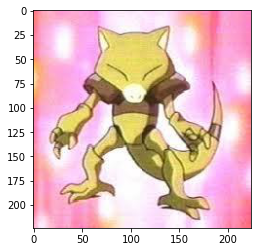

In [ ]:
from keras.preprocessing import image
img = image.load_img("/content/PokemonDataSplit/train/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg",target_size=(224,224))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [ ]:
# base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
# from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
# model = Sequential()
# model.add(Conv2D(filters = 64, activation = "relu",kernel_size=3, strides = 3,input_shape=(224,224,3)))
# model.add(MaxPool2D(pool_size=(2,2),strides = 2))

# model.add(Conv2D(filters = 64, padding = "same",activation = "relu",kernel_size=3))
# model.add(MaxPool2D(pool_size=(2,2),strides = 2))

# model.add(Flatten())
# model.add(Dense(128,activation="relu"))

# #Output layer
# model.add(Dense(150,activation = "softmax"))

In [ ]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
model = Sequential()
model.add(Conv2D(filters = 32, padding="same",activation = "relu",kernel_size=3, strides = 1,input_shape=(224,224,3)))
model.add(BatchNormalization(-1))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, padding="same",activation = "relu",kernel_size=3, strides = 3))
model.add(Dropout(0.25))
model.add(BatchNormalization(-1))

model.add(Conv2D(filters = 64, padding = "same",activation = "relu",kernel_size=3))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, padding = "same",activation = "relu",kernel_size=3))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters = 128, padding = "same",activation = "relu",kernel_size=3))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Output layer
model.add(Dense(150,activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 64)       

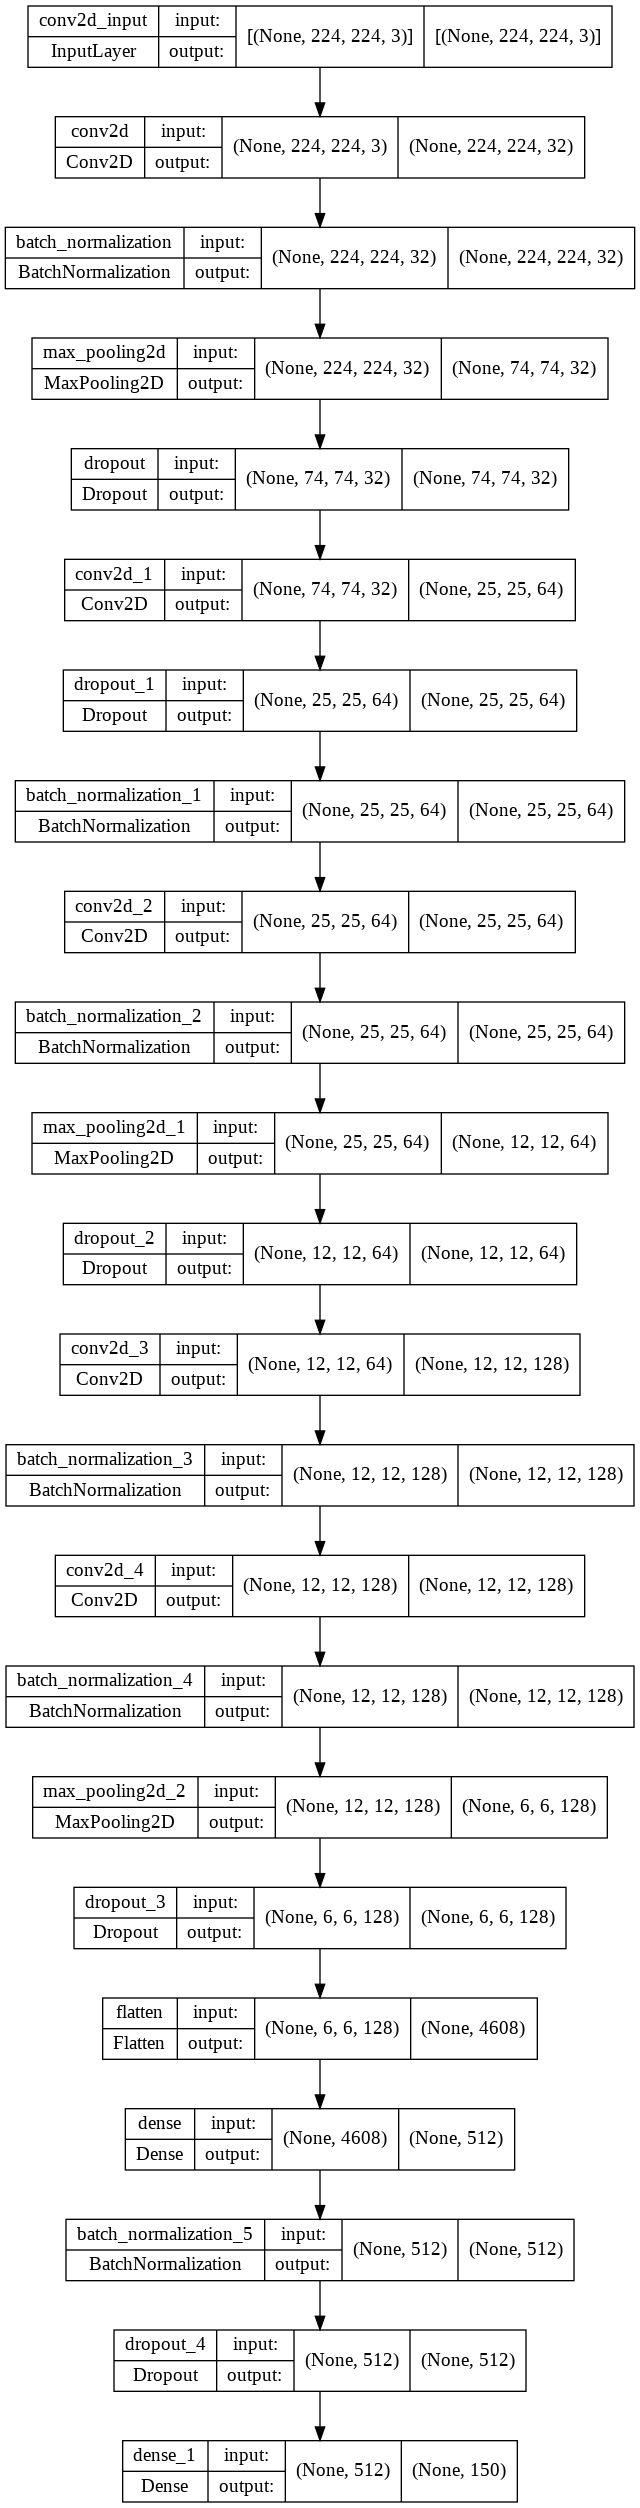

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(trainGen,validation_data=valGen,epochs = NUM_EPOCHS,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/30
169/169 [==============================] - 96s 502ms/step - loss: 4.7975 - accuracy: 0.0391 - val_loss: 5.9856 - val_accuracy: 0.0081 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 83s 493ms/step - loss: 3.8723 - accuracy: 0.1159 - val_loss: 5.1964 - val_accuracy: 0.0309 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 83s 491ms/step - loss: 3.4092 - accuracy: 0.1859 - val_loss: 3.2231 - val_accuracy: 0.2195 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 83s 491ms/step - loss: 3.1012 - accuracy: 0.2275 - val_loss: 2.7841 - val_accuracy: 0.2976 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 83s 490ms/step - loss: 2.8288 - accuracy: 0.2723 - val_loss: 2.3126 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 83s 490ms/step - loss: 2.6229 - accuracy: 0.3168 - val_loss: 2.0861 - val_accuracy: 0.4520 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

In [ ]:
# Save the neural network to disk
print("[INFO] serializing network to '{}'...".format(MODEL_NAME))
model.save(MODEL_NAME)

[INFO] serializing network to 'pokemon-classifier-cnn.model'...
INFO:tensorflow:Assets written to: pokemon-classifier-cnn.model/assets


In [ ]:
!zip -r /content/pokemon-classifier-model-cnn /content/pokemon-classifier-cnn.model

  adding: content/pokemon-classifier-cnn.model/ (stored 0%)
  adding: content/pokemon-classifier-cnn.model/variables/ (stored 0%)
  adding: content/pokemon-classifier-cnn.model/variables/variables.index (deflated 74%)
  adding: content/pokemon-classifier-cnn.model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/pokemon-classifier-cnn.model/assets/ (stored 0%)
  adding: content/pokemon-classifier-cnn.model/saved_model.pb (deflated 89%)
  adding: content/pokemon-classifier-cnn.model/keras_metadata.pb (deflated 94%)


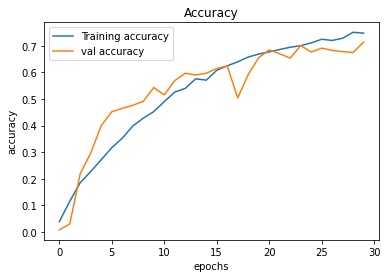

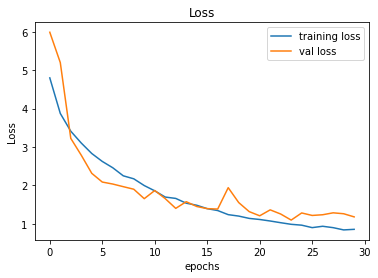

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()